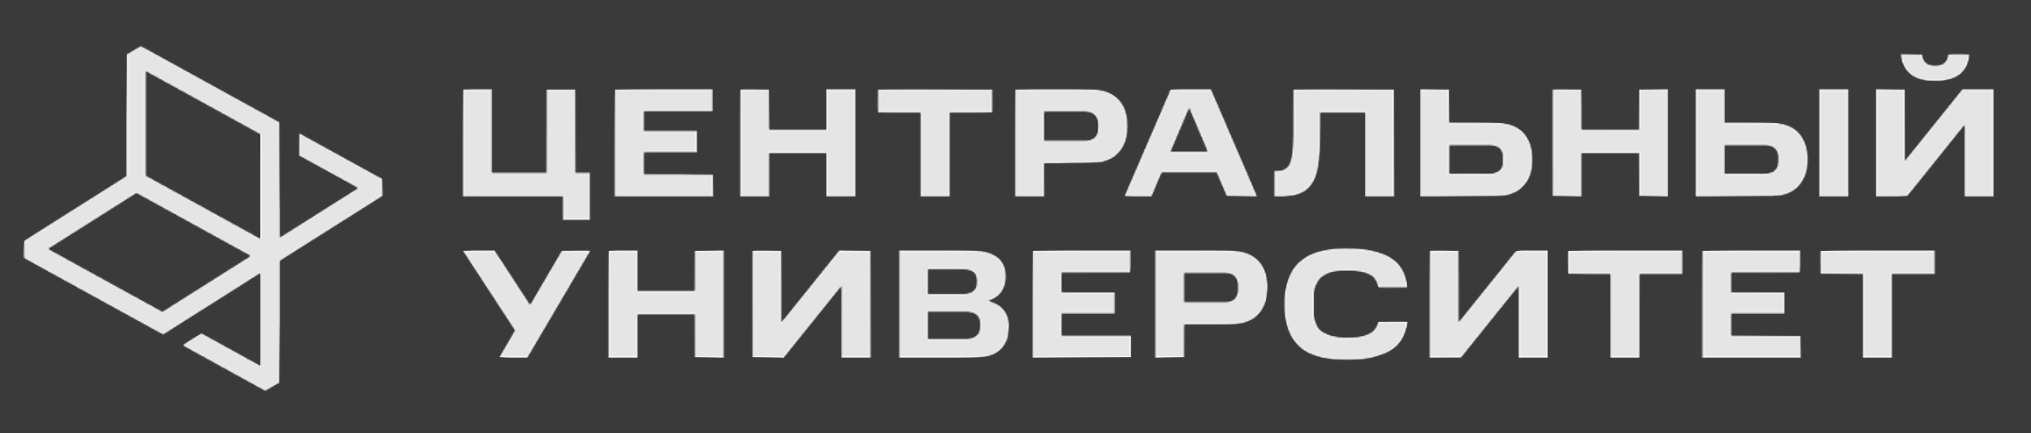

# Домашнее задание 8. Generative models.

## Максимальное кол-во баллов: 100

___
## Cроки

Дата выдачи: TBD

Жесткий дедлайн: TBD



---

# Важно! О формате сдачи

* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**
*  **Если в ячейке написана фраза "Вывод"/"Ответ на вопрос"/"Ваш текст" и пр., то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно).**
* **Если в ячейке написано "Your code here"/"Ваш код" и пр., то ожидается ответ в виде кода (можете добавить больше ячеек с кодом, если считаете это необходимым, но это необязательно).**
* **Если есть и ячейка с фразой "Вывод" и пр., и ячейка с фразой "Your code here" и пр., то в ответе ожидается и код, и текст)**
* **Если в формулировке задания явно не указывается сигнатура функции, можно пользоваться своими методами**
___


Привет! В этой домашке тебе предстоит подчинить себе генерацию, а именно реализовать conditional-варианты архитектур VAE/GAN

**Важно**:
1. архитектуры должны быть реализованы при помощи сверточных слоев `nn.Conv2d`, решения без сверток засчитываться не будут, но можно добавлять `nn.Linear` по необходимости
2. чекпоинты, ноутбук и используемые модули(архитектуры рекомендуется разбить на модули для читаемости) должны быть прикреплены к решению
3. можешь оставить requirements.txt чтобы облегчить проверяющим жизнь

---

## <font color='orange'>Задание 0: Данные [5 баллов]</font>

Работать будем с хорошо известным вам датасетом циферок, ниже его надо будет скачать при помощи `torchvision API`

![](https://user-images.githubusercontent.com/47734496/60438108-8b894000-9c2d-11e9-9cbb-1c06e3fb90a7.png)

Размер картинок: 28x28x1, трейн/тест сплиты: 60000, 10000

Лики данных допустимы, можете использовать все данные как трейн, только оставьте какую-то часть на валидацию(понадобится для графиков функций потерь)

---

### 0.1. [5 баллов]
### Формулировка задания:

1. Визуализируй семплы из датесетов для твоего:
- трейна
- инференса
2. Выведи размеры train/val сплитов


Нормализовывать картинки не обязательно, используй референсы ниже как пример

In [1]:
from torchvision.datasets import MNIST
import torchvision.transforms as T

train_transforms = T.Compose([
    T.ToTensor(),
])

val_transforms = T.Compose([
    T.ToTensor(),
])

train_dataset = MNIST(root='mnist_dataset', train=True, transform=train_transforms, download=True)
val_dataset = MNIST(root='mnist_dataset', train=False, transform=val_transforms, download=True)

len(train_dataset), len(val_dataset)

(60000, 10000)

In [2]:
import matplotlib.pyplot as plt
def show_transforms(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, label = dataset[i]
        ax = axes[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"{dataset.classes[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

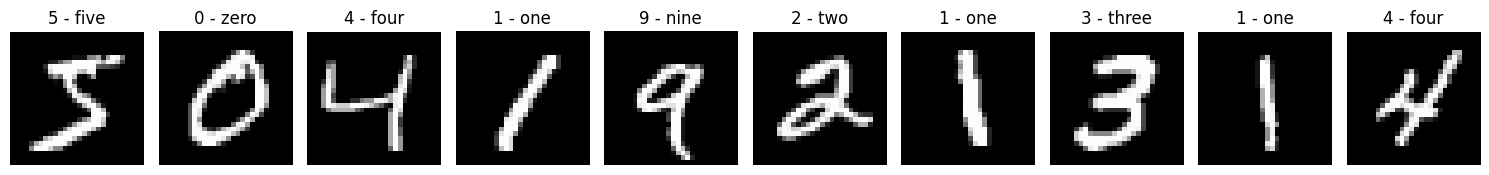

In [3]:
show_transforms(train_dataset, num_images=10)

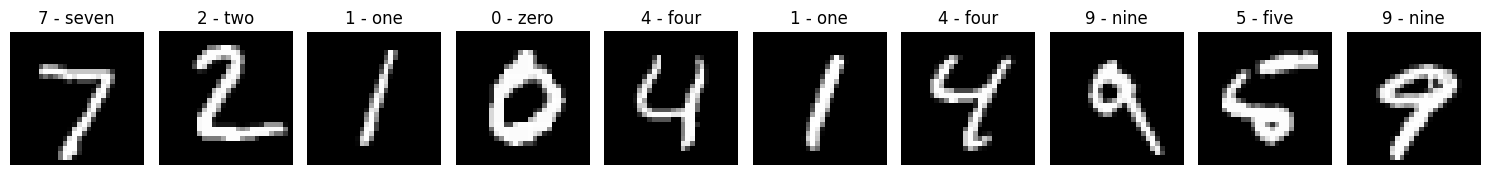

In [4]:
show_transforms(val_dataset, num_images=10)

---

## <font color='orange'>Задание 1: Conditional VAE [45 баллов] + 5 баллов за функцию метрики</font>

![](https://drive.google.com/uc?export=view&id=1-GQwHMBFpY8W1hiOO_yuIOh8yfcAox6D)

![](https://drive.google.com/uc?export=view&id=1DIAUPy88plSiuA8n9ElkLnmg8nTd-vuH)

Note: подумай как еще можно закодировать лейблы с помощью `nn.Embedding` вместо `one-hot`-представления. Скорее всего, так будет лучше учиться

---

### 1.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-автоэнкодер, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
        )

        self.connection = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x + self.layer(x)
        x = self.connection(x)
        return x

class CVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3),
            nn.BatchNorm2d(2),
            nn.ReLU(),

            nn.Conv2d(2, 4, kernel_size=3),
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.Conv2d(4, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.label_embedding = nn.Linear(10, latent_dim)

        self.sampler = nn.Linear(latent_dim, latent_dim)

        self.decoder_input = nn.Linear(latent_dim * 2, 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(8, 4, kernel_size=3),
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.ConvTranspose2d(4, 2, kernel_size=3),
            nn.BatchNorm2d(2),
            nn.ReLU(),

            nn.ConvTranspose2d(2, 1, kernel_size=3),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        batch_size = x.size(0)
        y_one_hot = F.one_hot(y, num_classes=10).float()
        y_embed = self.label_embedding(y_one_hot)

        x_encoded = self.encoder(x)
        x_encoded = x_encoded.view(batch_size, -1)
        mu, logvar = self.fc_mu(x_encoded), self.fc_logvar(x_encoded)
        z = self.reparameterize(mu, logvar)

        z_sampled = self.sampler(z)

        z_cond = torch.cat([z_sampled, y_embed], dim=1)
        z_cond = self.decoder_input(z_cond)
        z_cond = z_cond.view(batch_size, 64, 1, 1)
        x_recon = self.decoder(z_cond)
        
        return x_recon, mu, logvar

---

### 1.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов по эпохам на train/val сплитах(вторая картинка на референсе необязательная)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

In [6]:
from tqdm.notebook import tqdm

def train_autoencoder(model, train_loader, val_loader, epochs=20, lr=1e-3, weight_decay=0.01, device='cuda'):
    """
    Обучение Conditional VAE с использованием MSE (реконструкция) и KLD (разница между
    априорным и выводимым распределениями в латентном пространстве).
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.to(device)

    def loss_function(recon_x, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction="mean")
        kld_loss = -0.25 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        return recon_loss + kld_loss, recon_loss, kld_loss

    train_losses, val_losses = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            x_recon, mu, logvar = model(x, y)
            total_loss, recon_loss, kld_loss = loss_function(x_recon, x, mu, logvar)

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                x_recon, mu, logvar = model(x, y)
                total_loss, _, _ = loss_function(x_recon, x, mu, logvar)
                val_loss += total_loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Визуализируем кривые обучения
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History (BCE + KLD)')
    plt.show()

    return model

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1/12] | Train Loss: 0.2827 | Val Loss: 0.2280
Epoch [2/12] | Train Loss: 0.2271 | Val Loss: 0.2251
Epoch [3/12] | Train Loss: 0.2253 | Val Loss: 0.2237
Epoch [4/12] | Train Loss: 0.2245 | Val Loss: 0.2227
Epoch [5/12] | Train Loss: 0.2240 | Val Loss: 0.2226
Epoch [6/12] | Train Loss: 0.2237 | Val Loss: 0.2228
Epoch [7/12] | Train Loss: 0.2235 | Val Loss: 0.2222
Epoch [8/12] | Train Loss: 0.2234 | Val Loss: 0.2219
Epoch [9/12] | Train Loss: 0.2232 | Val Loss: 0.2221
Epoch [10/12] | Train Loss: 0.2231 | Val Loss: 0.2223
Epoch [11/12] | Train Loss: 0.2231 | Val Loss: 0.2218
Epoch [12/12] | Train Loss: 0.2230 | Val Loss: 0.2220


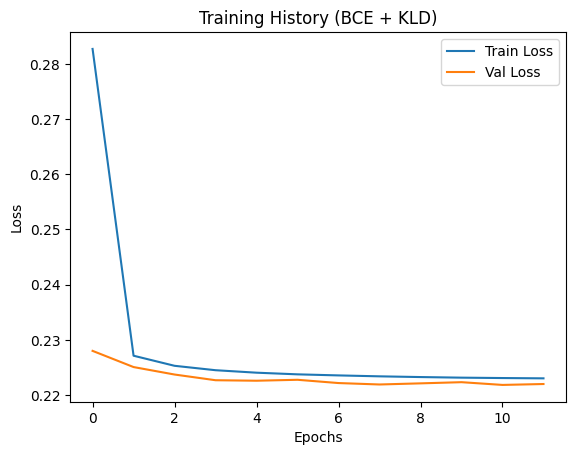

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)

model = CVAE(latent_dim=32).to('cuda')

trained_model = train_autoencoder(model, train_loader, val_loader, epochs=12, lr=1e-4, weight_decay=0.001, device='cuda')

torch.save(trained_model.state_dict(), 'cvae.ckpt')

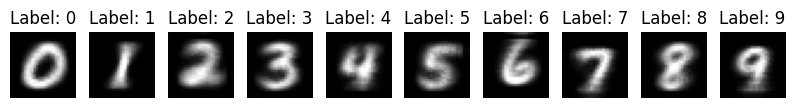

In [8]:
def generate_images(model, num_samples=10, latent_dim=32, device='cuda'):
    model.to(device)
    model.eval()

    z = torch.randn(num_samples, latent_dim).to(device)

    y = torch.arange(num_samples) % 10
    y = F.one_hot(y, num_classes=10).float().to(device)

    y_embed = model.label_embedding(y)

    z_cond = torch.cat([z, y_embed], dim=1)
    z_cond = model.decoder_input(z_cond)
    z_cond = z_cond.view(num_samples, 64, 1, 1)

    with torch.no_grad():
        generated_images = model.decoder(z_cond).cpu()

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {i % 10}")

    plt.show()

generate_images(trained_model, num_samples=10, latent_dim=32, device='cuda' if torch.cuda.is_available() else 'cpu')

---

### 1.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_vae(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=4, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [9]:
import torchvision.utils as vutils

@torch.no_grad
def show_grid_vae(model=None, digit=0, n_reps=1, device=None):
    """
    Визуализатор семлов CVAE.
            Параметры:
                    model torch.nn.Module: модель CVAE
                    digit (int): генерируемая цифра
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    None
    """

    if model is None:
        print("Модель не передана!")
        return
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)

    z = torch.randn(n_reps, model.latent_dim, device=device)

    y = torch.full((n_reps,), digit, dtype=torch.long, device=device)

    y_one_hot = F.one_hot(y, num_classes=10).float()
    y_embed = model.label_embedding(y_one_hot)

    z_sampled = model.sampler(z)

    z_cond = torch.cat([z_sampled, y_embed], dim=1)

    z_cond = model.decoder_input(z_cond)
    z_cond = z_cond.view(n_reps, 64, 1, 1)

    x_generated = model.decoder(z_cond)

    grid = vutils.make_grid(x_generated.cpu(), nrow=n_reps, normalize=True)
    plt.figure(figsize=(n_reps, 1))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Generated digit: {digit}')
    plt.show()

Пример:

In [10]:
checkpoint = torch.load('cvae.ckpt', map_location='cpu')

model = CVAE(latent_dim=32)
model.load_state_dict(checkpoint)

<All keys matched successfully>

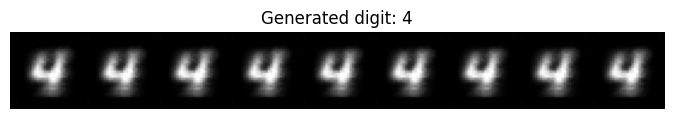

In [11]:
show_grid_vae(
    model=model,
    digit=4,
    n_reps=9,
    device='cuda',
)

---

### 1.4. [25 баллов] + 5 баллов за корректную реализацию функции из п.п. 1
### Формулировка задания:

1. Реализуй функцию `compute_acc_vae(...)`, используя шаблон ниже

2. Выведи результат для `n_reps=100`

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 25), где mean_acc лежит в [0, 1]


In [12]:
import torch.nn as nn
from collections import OrderedDict


class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [13]:
import torchvision.transforms as T
# from lenet import LeNet5
import torch

classiffier_model = LeNet5().eval()
classiffier_model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classiffier_model = classiffier_model.to('cuda')

transform = T.Compose([
    T.Resize(size=(32, 32), antialias=True)
])

In [14]:
@torch.no_grad()
def compute_acc_vae(model=None, n_reps=1, device=None):
    """
    CVAE accuracy.
    Алгоритм:
        1. цикл по цифрам 0..9
            a. генерируем n_reps цифр с одинаковым лейблом D
            b. считаем accuracy классификатора classiffier_model (в идеале все предикты должны быть D)
            c. сохраняем результат усредненной метрики в буфер
        2. Считаем (mean, std) для получившегося буфера
        3. Возвращаем (mean, std)

        Параметры:
            model (torch.nn.Module): модель CVAE
            n_reps (int): кол-во семплов на каждую цифру
            device (torch.device): на каком девайсе проводить вычисления
        Возвращаемое значение:
            (mean, std) (float, float)
    """

    model.eval()
    model.to(device)

    # Сюда будем сохранять точность по каждой цифре
    acc_values = []

    for digit in range(10):
        # 1. Генерируем n_reps семплов цифры digit
        # Случайный вектор z
        z = torch.randn(n_reps, model.latent_dim, device=device)
        # Метки
        y = torch.full((n_reps,), digit, dtype=torch.long, device=device)

        # Генерация
        y_one_hot = F.one_hot(y, num_classes=10).float()
        y_embed = model.label_embedding(y_one_hot)
        z_sampled = model.sampler(z)

        z_cond = torch.cat([z_sampled, y_embed], dim=1)
        z_cond = model.decoder_input(z_cond)
        z_cond = z_cond.view(n_reps, 64, 1, 1)
        x_generated = model.decoder(z_cond)

        # 2. Трансформируем (resize) и прогоняем через классификатор
        # Размер x_generated: (n_reps, 1, H, W). H, W скорее всего 28x28 => приводим к 32x32
        # Для совместимости с lenet
        images_resized = []
        for i in range(n_reps):
            # Переводим тензор в PIL и обратно
            img = x_generated[i].cpu().squeeze(0)  # shape: (H, W)
            # to range [0,1]
            # Переводим в PIL
            pil_img = T.ToPILImage()(img)
            # Применяем transform (resize)
            pil_img = transform(pil_img)
            # Снова в тензор
            tensor_img = T.ToTensor()(pil_img)
            images_resized.append(tensor_img)

        images_resized = torch.stack(images_resized, dim=0).to(device)  # shape: (n_reps, 1, 32, 32)

        # Предсказания
        logits = classiffier_model(images_resized)
        preds = logits.argmax(dim=1)
        # Считаем accuracy для текущей цифры
        correct = (preds == digit).float().sum()
        acc_digit = correct.item() / n_reps
        acc_values.append(acc_digit)

    acc_mean = float(torch.tensor(acc_values).mean().item())
    acc_std = float(torch.tensor(acc_values).std().item())

    print(f"CVAE Accuracy across digits: mean={acc_mean:.4f}, std={acc_std:.4f}")

    return acc_mean, acc_std


In [15]:
mu, sigma = compute_acc_vae(
    model=model,
    n_reps=100,
    device='cuda',
)

mu, sigma

CVAE Accuracy across digits: mean=1.0000, std=0.0000


(1.0, 0.0)

---

## <font color='orange'>Задание 2: Conditional GAN [45 баллов]</font>

![](https://drive.google.com/uc?export=view&id=1k0C7KI6hOrCuOpa4UmZMNPy2wnjZpaBO)

---

### 2.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-GAN, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [16]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size=28, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_size = img_size
        self.init_size = img_size // 4

        in_features = latent_dim + num_classes
        hidden = 128 * (self.init_size**2)

        self.l1 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        """
        noise: (batch_size, latent_dim)
        labels: (batch_size,) c целочисленными метками [0..9]
        """
        y_onehot = F.one_hot(labels, num_classes=self.num_classes).float()

        gen_input = torch.cat((noise, y_onehot), dim=1)  

        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super().__init__()
        self.img_size = img_size
        self.num_classes = num_classes
        in_features = img_size*img_size + num_classes

        self.model = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        """
        img: (batch_size, 1, 28, 28)
        labels: (batch_size,)
        """
        img_flat = img.view(img.size(0), -1)
        y_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        d_input = torch.cat((img_flat, y_onehot), dim=1)
        validity = self.model(d_input)
        return validity

---

### 2.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов генератора и дискриминатора по эпохам(вторая и третья картинки на референсе необязательные)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

In [17]:
def train_gan(
    model, 
    loader, 
    optimizer, 
    criterion, 
    n_epochs=50, 
    device='cuda', 
    log_step=1
):
    generator, discriminator = model
    optimizer_G, optimizer_D = optimizer
    adversarial_loss = criterion
    
    generator.to(device)
    discriminator.to(device)
    
    losses_g, losses_d, real_scores, fake_scores = [], [], [], []
    
    for epoch in range(n_epochs):
        for imgs, labels in loader:
            batch_size = imgs.size(0)
            imgs = imgs.to(device)
            labels = labels.to(device)

            real = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, generator.latent_dim, device=device)
            gen_labels = torch.randint(0, generator.num_classes, (batch_size,), device=device)
            gen_imgs = generator(noise, gen_labels)
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, real)
            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()
            real_validity = discriminator(imgs, labels)
            real_loss = adversarial_loss(real_validity, real)

            fake_validity = discriminator(gen_imgs.detach(), gen_labels)
            fake_loss = adversarial_loss(fake_validity, fake)

            d_loss = 0.5 * (real_loss + fake_loss)
            d_loss.backward()
            optimizer_D.step()

        losses_g.append(g_loss.item())
        losses_d.append(d_loss.item())
        real_scores.append(real_loss.item())
        fake_scores.append(fake_loss.item())

        if (epoch + 1) % log_step == 0:
            print(f"[Epoch {epoch+1}/{n_epochs}] G_loss: {g_loss.item():.4f} | D_loss: {d_loss.item():.4f}")

    plt.plot(losses_g, label="Generator loss")
    plt.plot(losses_d, label="Discriminator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator & Discriminator Loss')
    plt.show()

    return losses_g, losses_d, real_scores, fake_scores

[Epoch 1/128] G_loss: 4.2286 | D_loss: 0.2104
[Epoch 2/128] G_loss: 1.8672 | D_loss: 0.4002
[Epoch 3/128] G_loss: 3.7166 | D_loss: 0.2141
[Epoch 4/128] G_loss: 4.0336 | D_loss: 0.0365
[Epoch 5/128] G_loss: 3.2805 | D_loss: 0.0672
[Epoch 6/128] G_loss: 4.1607 | D_loss: 0.0128
[Epoch 7/128] G_loss: 5.7491 | D_loss: 0.0939
[Epoch 8/128] G_loss: 4.2040 | D_loss: 0.0215
[Epoch 9/128] G_loss: 3.0267 | D_loss: 0.1800
[Epoch 10/128] G_loss: 1.8369 | D_loss: 0.3980
[Epoch 11/128] G_loss: 3.9952 | D_loss: 0.5805
[Epoch 12/128] G_loss: 3.9469 | D_loss: 0.0771
[Epoch 13/128] G_loss: 8.7266 | D_loss: 0.0007
[Epoch 14/128] G_loss: 5.4140 | D_loss: 0.1422
[Epoch 15/128] G_loss: 4.3199 | D_loss: 0.1766
[Epoch 16/128] G_loss: 2.7411 | D_loss: 0.0503
[Epoch 17/128] G_loss: 2.9757 | D_loss: 0.1846
[Epoch 18/128] G_loss: 3.6190 | D_loss: 0.4315
[Epoch 19/128] G_loss: 6.6698 | D_loss: 0.1592
[Epoch 20/128] G_loss: 4.9284 | D_loss: 0.2140
[Epoch 21/128] G_loss: 5.2636 | D_loss: 0.0059
[Epoch 22/128] G_loss:

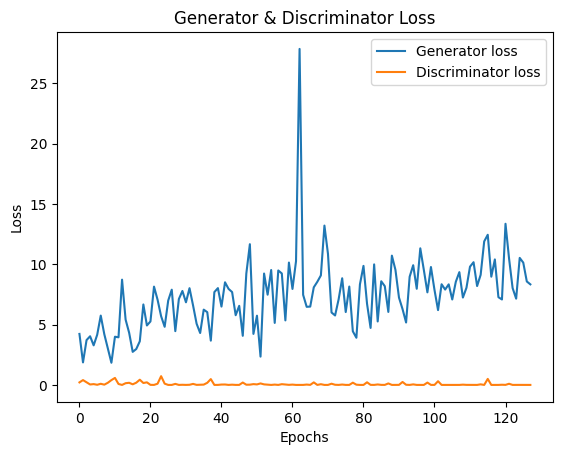

In [18]:
generator = Generator(latent_dim=100)
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

model = (generator, discriminator)
optimizer = (optimizer_G, optimizer_D)


losses_g, losses_d, real_scores, fake_scores = train_gan(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=128,
    device='cuda',
    log_step=1,
)

In [19]:
torch.save(generator.state_dict(), 'cgan.ckpt')

---

### 2.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_gan(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=8, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [20]:
@torch.no_grad
def show_grid_gan(model=None, digit=0, n_reps=1, device=None):
    """
    Визуализатор семплов cGAN.
    Параметры:
        model (nn.Module): генератор cGAN
        digit (int): цифра, которую хотим сгенерировать
        n_reps (int): количество генерируемых семплов
        device (torch.device): на каком устройстве генерировать

    Возвращает:
        None
    """
    if model is None:
        print("Модель не передана!")
        return

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    model.to(device)

    noise = torch.randn(n_reps, model.latent_dim, device=device)

    labels = torch.full((n_reps,), digit, dtype=torch.long, device=device)

    gen_imgs = model(noise, labels)

    grid = vutils.make_grid(gen_imgs.cpu(), nrow=n_reps, normalize=True)
    plt.figure(figsize=(n_reps, 1))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Generated digit: {digit}')
    plt.show()


Пример:

In [21]:
checkpoint = torch.load('cgan.ckpt', map_location='cpu')

model = Generator(latent_dim=100)
model.load_state_dict(checkpoint)

<All keys matched successfully>

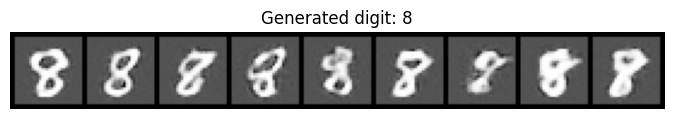

In [22]:
show_grid_gan(
    model,
    digit=8,
    n_reps=9,
    device='cuda',
)

---

### 2.4. [25 баллов]
### Формулировка задания:

1. Реализуй функцию ```compute_acc_gan(...)```, используя шаблон ниже

2. Выведи результат для `n_reps=100`

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 25), где mean_acc лежит в [0, 1]

In [23]:
import torchvision.transforms as T
# from lenet import LeNet5
import torch

classiffier_model = LeNet5().eval()
classiffier_model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classiffier_model = classiffier_model.to('cuda')

transform = T.Compose([
    T.Resize(size=(32, 32), antialias=True)
])

In [24]:
@torch.no_grad()
def compute_acc_gan(model=None, n_reps=1, device=None):
    """
    CGAN accuracy.
    Алгоритм:
        1. цикл по цифрам 0..9
            a. генерируем n_reps изображений с одинаковым лейблом digit
            b. классификатор classiffier_model предсказывает каждое изображение
            c. считаем, сколько предсказаний совпало с digit
        2. Считаем (mean, std) точности по всем цифрам
        3. Возвращаем (mean, std)

    Параметры:
        model (nn.Module): генератор cGAN
        n_reps (int): кол-во семплов на каждую цифру
        device (torch.device): девайс

    Возвращаемое значение:
        (mean, std) (float, float)
    """
    if model is None:
        print("Модель не передана!")
        return 0.0, 0.0

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    model.to(device)

    acc_values = []

    # Допустим у нас есть глобальный классификатор classiffier_model
    # и трансформация transform, например Resize(32,32).

    for digit in range(10):
        # Генерируем n_reps семплов цифры 'digit'
        noise = torch.randn(n_reps, model.latent_dim, device=device)
        labels = torch.full((n_reps,), digit, dtype=torch.long, device=device)

        # Генерация изображений
        gen_imgs = model(noise, labels)
        
        # Трансформируем и прогоняем через классификатор
        images_resized = []
        for i in range(n_reps):
            # (1, 28, 28) -> PIL -> resize -> tensor
            img = gen_imgs[i].cpu().squeeze(0)  # (28, 28)
            pil_img = T.ToPILImage()(img)
            pil_img = transform(pil_img)  # resize
            tensor_img = T.ToTensor()(pil_img)
            images_resized.append(tensor_img)

        images_resized = torch.stack(images_resized, dim=0)  # (n_reps, 1, 32, 32)
        images_resized = images_resized.to(device)

        logits = classiffier_model(images_resized)
        preds = logits.argmax(dim=1)
        correct = (preds == digit).float().sum().item()
        acc_digit = correct / n_reps
        acc_values.append(acc_digit)

    acc_mean = float(torch.tensor(acc_values).mean().item())
    acc_std = float(torch.tensor(acc_values).std().item())

    print(f"CGAN Accuracy across digits: mean={acc_mean:.4f}, std={acc_std:.4f}")

    return acc_mean, acc_std


In [25]:
mu, sigma = compute_acc_gan(
    model=model,
    n_reps=100,
    device='cuda',
)

mu, sigma

CGAN Accuracy across digits: mean=0.7380, std=0.2023


(0.7379999756813049, 0.20225398242473602)

---